In [2]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import time

In [3]:
# for parallelization if necessary
#from dask import compute, delayed
#from dask.distributed import Client, LocalCluster 
#cl = LocalCluster(n_workers=4)
#client = Client(cl)
#cl

# note: if this throws an error, close jupyter, run "ulimit -n 4096" in terminal, then restart jupyter

In [4]:
# define data location
location = '/Users/mithras/Documents/_SCHOOL/_Drexel/BUSN 710 - Capstone/Data/Forecasting Project/'
#location = '/Users/loki/Documents/Data/Forecasting Project/'

In [34]:
# read data from pickle

# what data granularity?
granularity = "daily"

# if we're clustering first, we need to load in sufficient_ data to ensure data equivalency across IDs
if granularity == "daily":
    readdata = pd.read_pickle(location+'peco_sufficient_daily.pkl.zip')
    weather = pd.read_pickle(location+'daily_weather.pkl.zip')
    ids = pd.read_pickle(location+'peco_sufficient_daily_ids.pkl.zip')
elif granularity == "hourly":
    readdata = pd.read_pickle(location+'peco_sufficient_hourly.pkl.zip')
    weather = pd.read_pickle(location+'hourly_weather.pkl.zip')
    ids = pd.read_pickle(location+'peco_sufficient_hourly_ids.pkl.zip')
else:
    print("Granularity selected was not 'daily' or 'hourly'")


In [6]:
readdata.head()

,DACCOUNTID,DMETERNO,Dt,ID,Use,DCUSTOMERID,TARIFF,FUELTYPE,REVENUCODE,Weekday,Holiday,TYPE
1199295,189118224335924,732846282212,2017-10-12,"(189118224335924, 732846282212)",1.0,14663049479224,GR0,GAS,1.0,1,0,HOME
85504,8884140853296,3881418627996,2017-10-12,"(8884140853296, 3881418627996)",0.0,138779913152,UHC,GAS,3.0,1,0,COMM
1381809,224154867687260,730682241528,2017-10-12,"(224154867687260, 730682241528)",1.0,2313284273540,GH0,GAS,1.0,1,0,HOME
2142920,357349866155308,792549695076,2017-10-12,"(357349866155308, 792549695076)",0.0,3647225894448,GHC,GAS,3.0,1,0,COMM
1442616,236128365767248,610644449116,2017-10-12,"(236128365767248, 610644449116)",1.0,8969140220032,GH0,GAS,1.0,1,0,HOME


## Cluster ##

In [7]:
# Cumulative Distribution Function Plot
def cdf(x):
    """cumulative distribution function of a variable"""
    # Sort in ascending order
    x = np.sort(x)
    n = len(x)
    
    # Go from 1/n to 1
    y = np.arange(1, n + 1, 1) / n
    
    return x, y

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
    
for code in readdata['TYPE'].drop_duplicates():
    data = readdata[(readdata['TYPE']==code)]
       
    scaled = data[['ID','Use']].groupby('ID')
    rTable_scaled[rTable.columns] = scaler.fit_transform(rTable[rTable.columns])

    variance = data[['ID','Use']].groupby('ID').var().reset_index()
    variance = variance.rename(columns={'Use':'use_var'})
    
    # plot
    f, ax = plt.subplots(figsize=(4,3))
    sns.set_style('whitegrid')

    xs, ys = cdf(np.array(variance['use_var']))
    plt.plot(xs, ys, '.')
    plt.ylabel('Percentile'); plt.title('CDF of Consumption Variance for TYPE: '+code); plt.xlabel('Consumption Variance');

NameError: name 'rTable' is not defined

Curve seems fairly continuous for both home and commecial
* We won't be able to easily identify a threshold where behavior shifts for winter
* There are outliers that may throw off kmeans; we should review cluster centroids to consider

### Kmeans ###

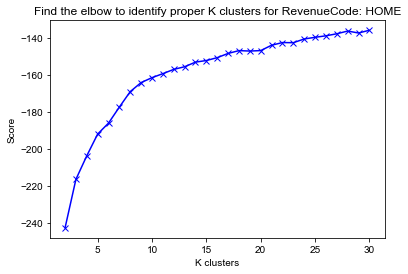

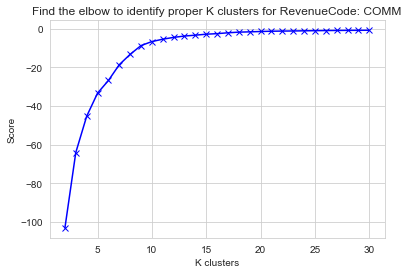

In [9]:
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans

for code in readdata['TYPE'].drop_duplicates():
    # break out by revenuecode
    data = readdata[(readdata['TYPE']==code)]
    # restructure data: keep bare minimum of use info; transition use into wide format
    ids = data[['ID','TYPE']].drop_duplicates()
    data = data.loc[:, data.columns.isin(['ID','TYPE','Dt','Use'])]
    data = data.pivot_table(values='Use', index=['ID','TYPE'], columns='Dt').reset_index()
    data = data.drop(columns='TYPE')
    data = data.dropna()

    # normalize
    scaled = data.drop(columns='ID')
    scaled = scale(scaled.values)

    # determine k using elbow method
    K = range(2,31)
    SSE = []
    for k in K:
        kmeanModel = KMeans(n_clusters=k)
        SSE.append(kmeanModel.fit(scaled).score(scaled)/len(scaled))

    # scree plot - find the elbow
    f, ax = plt.subplots(figsize=(6,4))
    sns.set_style('whitegrid')

    plt.plot(K, SSE, 'bx-')
    plt.xlabel('K clusters')
    plt.ylabel('Score')
    plt.title('Find the elbow to identify proper K clusters for RevenueCode: '+code)

It looks like there's an elbow at 10 for both home and commercial, though it's much more pronounced for commercial
* Error score is averaged by number of records so the error is comparable for both types
* We see error for commercial approach 0, which is probably not a good thing (may be overfitting)
    * likely overfitting to outliers
    * commercial gas use may be weird


In [10]:
from sklearn.preprocessing import scale

# it looks like there's an elbow at 10 for both home and commercial, though it's much more pronounced for commercial
codebook = {}

for code in readdata['TYPE'].drop_duplicates():
    # break out by revenuecode
    data = readdata[(readdata['TYPE']==code)]
    # restructure data: keep bare minimum of use info; transition use into wide format
    ids = data[['ID','TYPE']].drop_duplicates()
    data = data.loc[:, data.columns.isin(['ID','TYPE','Dt','Use'])]
    data = data.pivot_table(values='Use', index=['ID','TYPE'], columns='Dt').reset_index()
    data = data.drop(columns='TYPE')
    data = data.dropna()

    # normalize
    scaled = data.drop(columns='ID')
    scaled = scale(scaled.values)
    
    kmean10 = KMeans(n_clusters=10, random_state=10) 
    cluster = kmean10.fit(scaled).predict(scaled)
    ids['cluster'] = cluster
    codebook[code+str(10)] = pd.DataFrame(ids)
    
list(codebook)

['HOME10', 'COMM10']

In [11]:
home10 = codebook['HOME10']
comm10 = codebook['COMM10']   

list(home10)

['ID', 'TYPE', 'cluster']

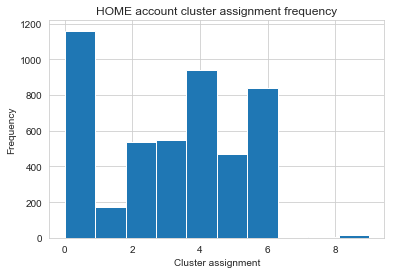

Text(0.5, 1.0, 'COMM account cluster assignment frequency')

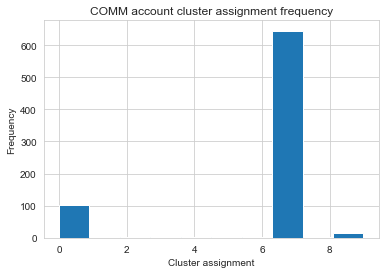

In [12]:

# home has a much more even distribution of cluster assignments than comm!
f, ax = plt.subplots(figsize=(6,4))
sns.set_style('whitegrid')
    
plt.hist(home10['cluster'], bins=10)
plt.xlabel('Cluster assignment')
plt.ylabel('Frequency')
plt.title('HOME account cluster assignment frequency')
plt.show() 

plt.hist(comm10['cluster'], bins=10)
plt.xlabel('Cluster assignment')
plt.ylabel('Frequency')
plt.title('COMM account cluster assignment frequency')

In [13]:
# merge id-level data and cluster assignment
home = pd.merge(readdata[['ID','TARIFF','REVENUCODE','TYPE']].drop_duplicates(), home10, how='inner', on=['ID','TYPE'])
comm = pd.merge(readdata[['ID','TARIFF','REVENUCODE','TYPE']].drop_duplicates(), comm10, how='inner', on=['ID','TYPE'])

In [14]:
# home crosstab tariff vs cluster
pd.crosstab(home.TARIFF,home.cluster)

cluster,0,1,2,3,4,5,6,7,8,9
TARIFF,,,,,,,,,,
GH0,910,131,421,414,728,365,652,1,2,15
GH5,1,1,0,0,1,0,1,0,0,0
GH8,14,0,5,5,8,2,5,0,0,0
GHC,0,0,0,0,1,0,0,0,0,0
GR0,35,4,26,25,33,19,33,0,0,0
GR5,1,0,0,0,1,0,0,0,0,0
GR8,1,2,2,4,2,3,2,0,0,0
UGH,198,32,83,104,161,82,149,0,0,2
UGR,9,0,5,3,6,2,5,0,0,0


In [15]:
# commercial crosstab tariff vs cluster
pd.crosstab(comm.TARIFF,comm.cluster)

cluster,0,1,2,3,4,5,6,7,8,9
TARIFF,,,,,,,,,,
GC0,19,0,0,1,0,0,0,78,0,1
GCE,0,0,0,0,0,0,0,2,0,0
GHC,52,0,1,0,2,1,1,360,0,8
GHE,0,0,0,0,0,0,0,8,0,0
MVF,0,0,0,0,0,0,0,1,0,0
TFG,0,0,0,0,0,0,0,7,0,0
TFL,2,0,0,0,0,0,0,3,0,1
TSI,1,0,0,0,0,0,0,2,0,0
UGC,7,0,0,0,0,0,0,43,0,0


### Explain home clusters ###

In [35]:
# calculate cluster centroids
data = readdata[(readdata['TYPE']=='HOME')]
data = data.loc[:, data.columns.isin(['ID','TYPE','Dt','Use'])]
data = data.pivot_table(values='Use', index=['ID','TYPE'], columns='Dt').reset_index()
data = pd.merge(data, home10, how='inner', on=['ID','TYPE'])
data = data.drop(columns='TYPE')
data = data.dropna()

home_centroids = data.groupby('cluster').mean().reset_index()

In [36]:
home_centroids.head()

,cluster,2017-10-12 00:00:00,2017-10-13 00:00:00,2017-10-14 00:00:00,2017-10-16 00:00:00,2017-10-17 00:00:00,2017-10-18 00:00:00,2017-10-19 00:00:00,2017-10-21 00:00:00,2017-10-22 00:00:00,...,2018-09-19 00:00:00,2018-09-20 00:00:00,2018-09-21 00:00:00,2018-09-22 00:00:00,2018-09-23 00:00:00,2018-09-24 00:00:00,2018-09-25 00:00:00,2018-09-26 00:00:00,2018-09-27 00:00:00,2018-09-28 00:00:00
0,0,0.503876,0.646813,0.544057,0.729087,1.456770,1.250775,0.935237,0.900353,0.875185,...,0.431619,0.393833,0.426718,0.402825,0.563127,0.481576,0.488045,0.451499,0.426133,0.482343
1,1,0.489824,0.584882,0.509588,0.645529,1.261118,1.069588,0.798000,0.802882,0.818882,...,0.498059,0.426000,0.516235,0.486294,0.508588,0.465588,0.506176,0.402529,0.452529,0.482471
2,2,0.513829,0.633123,0.571654,0.709963,1.454963,1.284981,1.002788,0.937100,0.902361,...,0.442249,0.452305,0.403625,0.405056,0.555558,0.490297,0.515167,0.417398,0.447788,0.475762
3,3,0.518073,0.615473,0.546309,0.680127,1.388073,1.253473,0.899927,0.867982,0.853855,...,0.453564,0.424709,0.368745,0.514345,0.598636,0.504618,0.466218,0.441855,0.487636,0.457655
4,4,0.536418,0.633721,0.522612,0.690096,1.384403,1.222004,0.923454,0.902345,0.844744,...,0.409733,0.425405,0.426013,0.443561,0.576397,0.463433,0.474286,0.460000,0.462388,0.456450


In [37]:
# transition centroids to tall format
home_centroids = pd.melt(home_centroids, id_vars='cluster',var_name='Dt', value_name='Use')

In [38]:
# add weather data
home_centroids = pd.merge(home_centroids, weather, how='inner', on='Dt')

# Add dummy variables for day-of-week
home_centroids = home_centroids.join(pd.get_dummies(home_centroids['Dt'].dt.weekday_name))

# Add dummy variables for holidays
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
dr = pd.date_range(start=min(home_centroids['Dt']), end=max(home_centroids['Dt']))
holidays = cal.holidays(start=dr.min(), end=dr.max())

home_centroids = home_centroids.join(pd.get_dummies(home_centroids['Dt'].isin(holidays)))
home_centroids = home_centroids.rename(columns={True:'Holiday'})
home_centroids = home_centroids.drop(columns=[False])

home_centroids.head()

,cluster,Dt,Use,AvgTemp,HighDB,LowDB,Temp1,Temp1delta,HighDB1,HighDB1delta,...,Cloud1,Cloud1delta,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Holiday
0,0,2017-10-12,0.503876,61.166667,67,57,70.833333,-9.666667,78.0,-11.0,...,89.166667,3.75,0,0,0,0,1,0,0,0
1,1,2017-10-12,0.489824,61.166667,67,57,70.833333,-9.666667,78.0,-11.0,...,89.166667,3.75,0,0,0,0,1,0,0,0
2,2,2017-10-12,0.513829,61.166667,67,57,70.833333,-9.666667,78.0,-11.0,...,89.166667,3.75,0,0,0,0,1,0,0,0
3,3,2017-10-12,0.518073,61.166667,67,57,70.833333,-9.666667,78.0,-11.0,...,89.166667,3.75,0,0,0,0,1,0,0,0
4,4,2017-10-12,0.536418,61.166667,67,57,70.833333,-9.666667,78.0,-11.0,...,89.166667,3.75,0,0,0,0,1,0,0,0


In [39]:
list(home_centroids)

['cluster',
 'Dt',
 'Use',
 'AvgTemp',
 'HighDB',
 'LowDB',
 'Temp1',
 'Temp1delta',
 'HighDB1',
 'HighDB1delta',
 'LowDB1',
 'LowDB1delta',
 'AvgHumid',
 'Humid1',
 'Humid1delta',
 'AvgWind',
 'Wind1',
 'Wind1delta',
 'AvgDaytimeCloud',
 'AvgCloud',
 'Cloud1',
 'Cloud1delta',
 'Friday',
 'Monday',
 'Saturday',
 'Sunday',
 'Thursday',
 'Tuesday',
 'Wednesday',
 'Holiday']

In [51]:
# run regression per cluster
import statsmodels.api as sm
import statsmodels.formula.api as smf


# run regressions; add equation to table
for cluster in home_centroids['cluster'].unique():
    data = home_centroids[(home_centroids['cluster']==cluster)]
    X = data.drop(columns=['cluster','Dt','Use'])
    y = data['Use']
    
    results = smf.ols('Use ~ AvgTemp + HighDB + LowDB + Temp1 + Temp1delta + HighDB1 + HighDB1delta + \
                      LowDB1 + LowDB1delta + AvgHumid + Humid1 + Humid1delta + AvgWind + Wind1 + \
                      Wind1delta + AvgDaytimeCloud + AvgCloud + Cloud1 + Cloud1delta + \
                      Friday + Monday + Saturday + Sunday + Thursday + Tuesday + Wednesday + Holiday', 
                      data=data).fit()
    print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                    Use   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     176.2
Date:                Mon, 22 Oct 2018   Prob (F-statistic):          4.92e-153
Time:                        17:29:37   Log-Likelihood:                -301.82
No. Observations:                 322   AIC:                             645.6
Df Residuals:                     301   BIC:                             724.9
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           9.1506      0.318     

                            OLS Regression Results                            
Dep. Variable:                    Use   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     174.4
Date:                Mon, 22 Oct 2018   Prob (F-statistic):          2.06e-152
Time:                        17:29:37   Log-Likelihood:                -303.37
No. Observations:                 322   AIC:                             648.7
Df Residuals:                     301   BIC:                             728.0
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           9.1336      0.319     

In [38]:
# run regression per cluster
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from itertools import chain

regr = linear_model.LinearRegression()

# create table of each cluster's regression equations
rTable = pd.DataFrame(index=(['intercept']+list(home_centroids)[3:] + ['MSE','R2']))

# run regressions; add equation to table
for cluster in home_centroids['cluster'].unique():
    data = home_centroids[(home_centroids['cluster']==cluster)]
    X = data.drop(columns=['cluster','Dt','Use'])
    y = data['Use']
    
    # fit the regression model
    regr.fit(X, y)
    
    # extract model coefficients
    intercept = regr.intercept_
    coefs = regr.coef_
    err = mean_squared_error(y, regr.predict(X))
    r2 = regr.score(X,y)
    #print([intercept]+list(chain(coefs))+[err]+[r2])
    rTable['cluster'+str(cluster)] = [intercept]+list(chain(coefs))+[err]+[r2]

rTable = rTable.T
#rTable.to_csv(location+'daily_home_clusters.csv')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


In [39]:
rTable

,intercept,AvgTemp,HighDB,LowDB,Temp1,Temp1delta,HighDB1,HighDB1delta,LowDB1,LowDB1delta,...,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Holiday,MSE,R2
cluster0,1.047097e+09,6.356750e+11,-2.453885e+11,1.406305e+10,-6.356750e+11,-6.356750e+11,2.453885e+11,2.453885e+11,-1.406305e+10,-1.406305e+10,...,-1.047097e+09,-1.047097e+09,-1.047097e+09,-1.047097e+09,-1.047097e+09,-1.047097e+09,-1.047097e+09,0.575940,0.381037,0.921426
cluster1,9.603590e+08,5.830176e+11,-2.250612e+11,1.289811e+10,-5.830176e+11,-5.830176e+11,2.250612e+11,2.250612e+11,-1.289811e+10,-1.289811e+10,...,-9.603590e+08,-9.603590e+08,-9.603590e+08,-9.603590e+08,-9.603590e+08,-9.603590e+08,-9.603590e+08,0.531813,0.339723,0.914320
cluster2,1.030559e+09,6.256349e+11,-2.415127e+11,1.384094e+10,-6.256349e+11,-6.256349e+11,2.415127e+11,2.415127e+11,-1.384094e+10,-1.384094e+10,...,-1.030559e+09,-1.030559e+09,-1.030559e+09,-1.030559e+09,-1.030559e+09,-1.030559e+09,-1.030559e+09,0.585872,0.357905,0.925441
cluster3,1.038625e+09,6.305314e+11,-2.434029e+11,1.394926e+10,-6.305314e+11,-6.305314e+11,2.434029e+11,2.434029e+11,-1.394926e+10,-1.394926e+10,...,-1.038625e+09,-1.038625e+09,-1.038625e+09,-1.038625e+09,-1.038625e+09,-1.038625e+09,-1.038625e+09,0.596532,0.372722,0.921372
cluster4,1.005563e+09,6.104602e+11,-2.356549e+11,1.350523e+10,-6.104602e+11,-6.104602e+11,2.356549e+11,2.356549e+11,-1.350523e+10,-1.350523e+10,...,-1.005563e+09,-1.005563e+09,-1.005563e+09,-1.005563e+09,-1.005563e+09,-1.005563e+09,-1.005563e+09,0.554951,0.358263,0.922652
cluster5,1.060996e+09,6.441125e+11,-2.486456e+11,1.424971e+10,-6.441125e+11,-6.441125e+11,2.486456e+11,2.486456e+11,-1.424971e+10,-1.424971e+10,...,-1.060996e+09,-1.060996e+09,-1.060996e+09,-1.060996e+09,-1.060996e+09,-1.060996e+09,-1.060996e+09,0.605616,0.385107,0.920592
cluster6,1.015078e+09,6.162363e+11,-2.378846e+11,1.363301e+10,-6.162363e+11,-6.162363e+11,2.378846e+11,2.378846e+11,-1.363301e+10,-1.363301e+10,...,-1.015078e+09,-1.015078e+09,-1.015078e+09,-1.015078e+09,-1.015078e+09,-1.015078e+09,-1.015078e+09,0.557988,0.371624,0.923444
cluster7,1.002874e+09,6.088279e+11,-2.350247e+11,1.346911e+10,-6.088279e+11,-6.088279e+11,2.350247e+11,2.350247e+11,-1.346911e+10,-1.346911e+10,...,-1.002874e+09,-1.002874e+09,-1.002874e+09,-1.002874e+09,-1.002874e+09,-1.002874e+09,-1.002874e+09,0.649735,0.613880,0.946773
cluster8,2.028211e+07,1.231292e+10,-4.753134e+09,2.723990e+08,-1.231292e+10,-1.231292e+10,4.753134e+09,4.753134e+09,-2.723990e+08,-2.723990e+08,...,-2.028210e+07,-2.028210e+07,-2.028210e+07,-2.028210e+07,-2.028210e+07,-2.028210e+07,-2.028210e+07,0.348327,0.142714,0.544892
cluster9,1.104725e+09,6.706600e+11,-2.588937e+11,1.483703e+10,-6.706600e+11,-6.706600e+11,2.588937e+11,2.588937e+11,-1.483703e+10,-1.483703e+10,...,-1.104725e+09,-1.104725e+09,-1.104725e+09,-1.104725e+09,-1.104725e+09,-1.104725e+09,-1.104725e+09,0.666307,0.387755,0.912650


In [48]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

rTable_scaled = pd.DataFrame(scaler.fit_transform(rTable), columns=rTable.columns)
#rTable_scaled.to_csv(location+'daily_home_clusters_scaled.csv')
rTable_scaled

,intercept,AvgTemp,HighDB,LowDB,Temp1,Temp1delta,HighDB1,HighDB1delta,LowDB1,LowDB1delta,...,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Holiday,MSE,R2
0,0.388504,0.388504,-0.388504,0.388504,-0.388504,-0.388504,0.388504,0.388504,-0.388504,-0.388504,...,-0.388504,-0.388504,-0.388504,-0.388504,-0.388504,-0.388504,-0.388504,0.104074,0.093729,0.316892
1,0.104087,0.104087,-0.104087,0.104087,-0.104087,-0.104087,0.104087,0.104087,-0.104087,-0.104087,...,-0.104087,-0.104087,-0.104087,-0.104087,-0.104087,-0.104087,-0.104087,-0.427972,-0.294914,0.254461
2,0.334274,0.334274,-0.334274,0.334274,-0.334274,-0.334274,0.334274,0.334274,-0.334274,-0.334274,...,-0.334274,-0.334274,-0.334274,-0.334274,-0.334274,-0.334274,-0.334274,0.223834,-0.123870,0.352166
3,0.360722,0.360722,-0.360722,0.360722,-0.360722,-0.360722,0.360722,0.360722,-0.360722,-0.360722,...,-0.360722,-0.360722,-0.360722,-0.360722,-0.360722,-0.360722,-0.360722,0.352359,0.015511,0.316411
4,0.252312,0.252312,-0.252312,0.252312,-0.252312,-0.252312,0.252312,0.252312,-0.252312,-0.252312,...,-0.252312,-0.252312,-0.252312,-0.252312,-0.252312,-0.252312,-0.252312,-0.148991,-0.120508,0.327659
5,0.434077,0.434077,-0.434077,0.434077,-0.434077,-0.434077,0.434077,0.434077,-0.434077,-0.434077,...,-0.434077,-0.434077,-0.434077,-0.434077,-0.434077,-0.434077,-0.434077,0.461880,0.132022,0.309562
6,0.283510,0.283510,-0.283510,0.283510,-0.283510,-0.283510,0.283510,0.283510,-0.283510,-0.283510,...,-0.283510,-0.283510,-0.283510,-0.283510,-0.283510,-0.283510,-0.283510,-0.112377,0.005186,0.334622
7,0.243495,0.243495,-0.243495,0.243495,-0.243495,-0.243495,0.243495,0.243495,-0.243495,-0.243495,...,-0.243495,-0.243495,-0.243495,-0.243495,-0.243495,-0.243495,-0.243495,0.993830,2.284127,0.539574
8,-2.978448,-2.978448,2.978448,-2.978448,2.978448,2.978448,-2.978448,-2.978448,2.978448,2.978448,...,2.978448,2.978448,2.978448,2.978448,2.978448,2.978448,2.978448,-2.640284,-2.148212,-2.991136
9,0.577467,0.577467,-0.577467,0.577467,-0.577467,-0.577467,0.577467,0.577467,-0.577467,-0.577467,...,-0.577467,-0.577467,-0.577467,-0.577467,-0.577467,-0.577467,-0.577467,1.193647,0.156928,0.239789


In [ ]:
# PCA
pca2 = PCA(n_components=2, whiten=True)
X_pca_1cw = pca1.fit_transform(data_scaled)
plt.scatter(X_pca_1cw[:,0], X_pca_1cw[:,1], c=iris.target,
alpha=0.8, s=60, marker='o', edgecolors='white')
plt.show()
pca_2cw.explained_variance_ratio_.sum() 

In [ ]:
# visualize cluster identities using PCA on weight vector

In [ ]:
# visualize rate-code identities using PCA on weight vector

In [ ]:
# append cluster ID to daily/hourly set

In [5]:
# close dask cluster (if used)
#cl.close

<bound method LocalCluster.close of LocalCluster('tcp://127.0.0.1:63002', workers=1, ncores=1)>